In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import gymnasium as gym
import os
import qiskit
from gymnasium import spaces
from stable_baselines3 import PPO, A2C, DQN, TD3, SAC
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecNormalize

from qiskit.quantum_info import random_density_matrix, random_statevector, DensityMatrix
from adaptive_qst.plotting import PlotOneQubit
from adaptive_qst.max_info import Posterior, HiddenState
#from adaptive_qst.rl_qst import AQSTEnv
import matplotlib.pyplot as plt
from numpy import pi
from qiskit.quantum_info import state_fidelity

from numpy import sqrt, log
from numpy.linalg import cholesky

## Reward engineering
- Rewards are roughly based on fidelity of posterior - but how exactly?

In [7]:
pure_infids = np.load("data/avg_fidelity_pure.npz")['arr_1']
pure_infids.shape

(50, 3, 50)

Default infidelities:

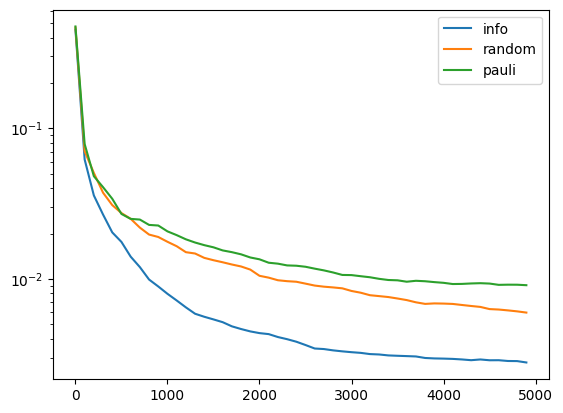

In [10]:
avgs = np.mean(pure_infids, axis = 0)

n_measurements = 5000
data_freq = 100

plt.plot(np.arange(0, n_measurements, data_freq), avgs[0], label = "info")
plt.plot(np.arange(0, n_measurements, data_freq), avgs[1], label = "random")
plt.plot(np.arange(0, n_measurements, data_freq), avgs[2], label = "pauli")

plt.yscale('log')
plt.legend()

Reward engineering - try to create a reward that is approximately constant over time, and that distinguishes between optimal and unoptimal measurement

- Found: -log(infidelity)/log(x + c), c is some constant

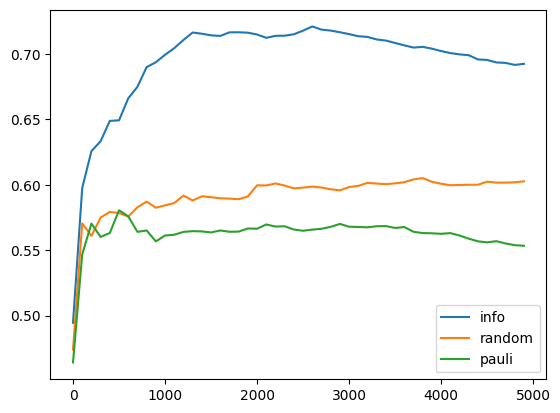

In [25]:
x_arr = np.arange(0, n_measurements, data_freq)
c = 5

plt.plot(x_arr, -log(avgs[0]) / log(x_arr + c), label = "info")
plt.plot(x_arr, -log(avgs[1])/ log(x_arr + c), label = "random")
plt.plot(x_arr, -log(avgs[2]) / log(x_arr + c), label = "pauli")

plt.legend()

Reward sparsity test: Have sparse enough rewards so that the training is and fast - but not too sparse!

- Time per reward found: 0.04 sec
- Time for 1000 measurements (no rewards): 3.42 seconds
- So getting rewards every 20 measurements slows training by about 2 seconds, or 50 percent of the time

Environment number test - have enough environments so that reward for a certain policy is stable
- 16 environments seems quite stable

In [50]:
def get_avg_infidelity(hidden_state, posterior):
    fids = map(lambda x: state_fidelity(hidden_state.hidden_state, x), posterior.particle_states)
    return 1 - np.sum(np.array(list(fids)) * posterior.particle_weights)

n_tests = 100
start = time.time()

hidden_state = HiddenState()
posterior = Posterior(n_particles = 30)
for _ in range(n_tests):
    get_avg_infidelity(hidden_state, posterior)

print(f"Time taken per: {(time.time() - start) / n_tests} seconds")

Time taken per: 0.042688772678375245 seconds


In [ ]:
n_measurements = 1000
n_envs = 64
measure_freq = 20

rewards = np.zeros((n_envs, n_measurements // measure_freq))

import time
start = time.time()
for i in range(n_envs):
    print(f"env {i}")
    posterior = Posterior(n_particles = 30)
    hidden_state = HiddenState(DensityMatrix(random_statevector(2)).data)
    
    for j in range(n_measurements):

        config = pi * np.random.rand(2,)

        result = hidden_state.measure_along_axis(config)
        posterior.update(config, result)
        
        if j % measure_freq == 0:
            rewards[i, j // measure_freq] = -log(get_avg_infidelity(hidden_state, posterior)) / log(j + c)

print(f"Time taken per: {(time.time() - start) / n_envs} seconds")

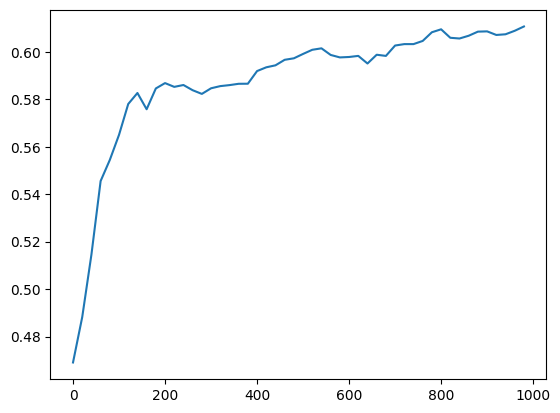

In [113]:
##See how different combinations of n_envs affect the resulting reward
n_envs = 64
avgs = np.mean(rewards[np.random.permutation(64)][:n_envs], axis = 0)

plt.plot(np.arange(0, n_measurements, measure_freq), avgs)

## Custom Environment

In [14]:
from scipy.stats import boxcox

class AQSTEnv(gym.Env):
    
    stable_const = 5 ##For reward stabilization
    def __init__(self, n_particles = 30, n_measurements = 1000, hidden_state = None, reward_freq = 20, is_pure = True):
        super(AQSTEnv, self).__init__()
        
        self.n_particles = n_particles
        self.n_measurements = n_measurements
        self.change_state = (hidden_state is None)
        self.reward_freq = reward_freq
        self.is_pure = is_pure
        
        
        self.posterior = Posterior(self.n_particles)
        
        if self.change_state and self.is_pure:
            self.hidden_state = HiddenState(DensityMatrix(random_statevector(2)).data)
            
        elif self.change_state and not self.is_pure:
            self.hidden_state = HiddenState()   
            
        else:
            self.hidden_state = hidden_state
    
        self.step_num = 0

        self.observation_space = gym.spaces.Box(low = -np.inf, high = np.inf, shape = (4 * self.n_particles,))  ##3 variables per density matrix, 1 variable for weight
        
        self.action_space = gym.spaces.Box(low= -1, high = 1, shape = (2,))  ##Orientation of measurement

    def step(self, action):
        
        config = (action + 1) * pi / 2
        result = self.hidden_state.measure_along_axis(config)
        self.posterior.update(config, result)
        self.step_num += 1
        
        if self.step_num % self.reward_freq == 0:
            reward = -log(self.get_avg_infidelity()) / log(self.step_num + self.stable_const)
        else:
            reward = 0

        truncated = (self.step_num >= self.n_measurements)
        terminated = False

        return (self.get_observations(), 
                reward, 
                terminated, 
                truncated, 
                {})

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)

        self.posterior = Posterior(self.n_particles)
        
        if self.change_state and self.is_pure:
            self.hidden_state = HiddenState(DensityMatrix(random_statevector(2)).data)
            
        elif self.change_state and not self.is_pure:
            self.hidden_state = HiddenState()   
            
        self.step_num = 0
        
        return self.get_observations(), {}
    
    def get_avg_infidelity(self):
        fids = map(lambda x: state_fidelity(self.hidden_state.hidden_state, x), self.posterior.particle_states)
        return 1 - np.sum(np.array(list(fids)) * self.posterior.particle_weights)    
    
    #Package complex density matrix and weights into observation vector (x, y, z positions)
    def get_observations(self):
        observations = np.zeros(4 * self.n_particles)
        perm = np.random.permutation(self.n_particles)
        particle_states = self.posterior.particle_states[perm]
        particle_weights = self.posterior.particle_weights[perm]
        
        observations[:self.n_particles] = 2 * np.real(particle_states[:, 0, 0]) - 1
        observations[self.n_particles : 2 * self.n_particles] = 2 * np.real(particle_states[:, 0, 1])
        observations[2 * self.n_particles : 3 * self.n_particles] = 2 * np.imag(particle_states[:, 0, 1])
        observations[3 * self.n_particles:] = (boxcox(particle_weights, 0.2))
        

        observations[:3 * self.n_particles] = observations[:3 * self.n_particles] / 2 + 0.5

        return observations.astype(np.float32)

In [4]:
env = AQSTEnv()
check_env(env, warn=True)

Random/maxinfo testing of the environment:

In [61]:
RL = 0
INFO = 1
RANDOM = 2
CONSTANT = 3

##env is wrapped in a vecnormalize for the sake of the model
def observe_run(model_type, model = None, **kwargs):
    
    env = VecNormalize(DummyVecEnv([lambda: AQSTEnv(**kwargs)]), norm_obs = True, norm_reward = False)
    
    obs = env.reset()
    actions = np.zeros((n_steps, 2))
    rewards = np.zeros(n_steps)
    for i in range(n_steps):
        episode_rewards = []
        done = False
        
        if model_type == RL:
            action, _states = model.predict(obs, deterministic = True)
            
        elif model_type == INFO:
            posterior = (env.venv.get_attr('posterior'))
            
            action = [posterior[0].get_best_config() * 2 / pi - 1]
            
        elif model_type == RANDOM:
            action = [2 * np.random.rand(2) - 1]
        
        elif model_type == CONSTANT:
            action = [np.array([0, 0])]
            
        else:
            print("Invalid model type!")
            return
        
        obs, reward, done, _info = env.step(action)
        actions[i] = action[0]
        rewards[i] = reward[0]
        
    return actions, rewards

observe_run(CONSTANT)

(array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.22736387,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.19952099,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.1536324 ,
        0.        , 0.        , 0.        , 0.        , 0.   

In [29]:
import time

n_steps = 1000
n_envs = 16
rews = np.zeros((n_envs, 2, n_steps))
start = time.time()

for i in range(0, n_envs):
    print(f"env {i}")
    
    rews[i, 0] = observe_run(model_type = INFO)[1]
    
    rews[i, 1] = observe_run(model_type = RANDOM)[1]
        
print(f"{time.time() - start}")

env 0
env 1
env 2
env 3
env 4
env 5
env 6
env 7
env 8
env 9
env 10
env 11
env 12
env 13
env 14
env 15
213.48563957214355


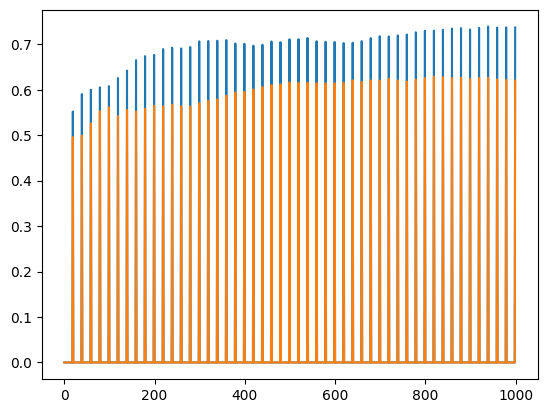

In [30]:
plt.plot(np.arange(n_steps), np.mean(rews, axis = 0)[0])
plt.plot(np.arange(n_steps), np.mean(rews, axis = 0)[1])

## Comparison between models

In [2]:
def get_avg(n_tests, n_steps, model_type, model = None, hidden_state = None, n_particles = 30):
    sums = np.zeros(n_steps)
    for i in range(n_tests):
        print(i)
        sums += observe(n_steps, model_type, model, hidden_state, n_particles)[1]
        
    return sums / n_tests

# info_avg = get_avg(n_tests = 32, n_steps = 500, model_type = INFO)
# random_avg = get_avg(n_tests = 32, n_steps = 500, model_type = RANDOM)
# constant_avg = get_avg(n_tests = 32, n_steps = 500, model_type = CONSTANT)

## Featurization
Want to have approximately normally distributed features... is this what we observe?

In [ ]:
n_steps = 100
n_tests = 100
n_particles = 30

obs_arr = np.zeros((n_tests, n_steps, n_particles * 4))
rew_arr = np.zeros((n_tests, n_steps - 1))


for i in range(n_tests):
    print(f"running {i}")
    env = AQSTEnv(n_measurements = n_steps + 10, n_particles = n_particles)
    
    obs, _ = env.reset()
    obs_arr[i, 0] = obs
    
    for j in range(1, n_steps):
        action = 2 * np.random.rand(2) - 1
        obs, reward, truncated, terminated, _info = env.step(action)
            
        obs_arr[i, j] = obs
        rew_arr[i, j - 1] = reward

In [24]:
obs_arr.shape
rew_arr.shape

(100, 99)

(array([4709., 2890., 2657., 2611., 2548., 2543., 2469., 2408., 2476.,
        2451., 2467., 2446., 2361., 2482., 2606., 2617., 2671., 2695.,
        2683., 2828., 2978., 2936., 3077., 3022., 3170., 3201., 3264.,
        3305., 3358., 3363., 3423., 3389., 3576., 3769., 3687., 3753.,
        3737., 3796., 3988., 4318., 4238., 4280., 4406., 4518., 4442.,
        4568., 4712., 4648., 4700., 4823., 4869., 4862., 5090., 5117.,
        5291., 5240., 5400., 8243., 5329., 5428., 5306., 5336., 5327.,
        5131., 4992., 4665., 4463., 4423., 4184., 3835., 3519., 3102.,
        2730., 2488., 2038., 1818., 1613., 1392., 1255., 1171., 1003.,
        1025.,  867.,  746.,  721.,  628.,  551.,  478.,  356.,  331.,
         263.,  264.,  230.,  213.,  183.,  140.,  110.,   85.,   66.,
          20.]),
 array([7.94728597e-08, 7.38938868e-03, 1.47786979e-02, 2.21680071e-02,
        2.95573163e-02, 3.69466255e-02, 4.43359347e-02, 5.17252439e-02,
        5.91145531e-02, 6.65038623e-02, 7.38931715e-02, 8.

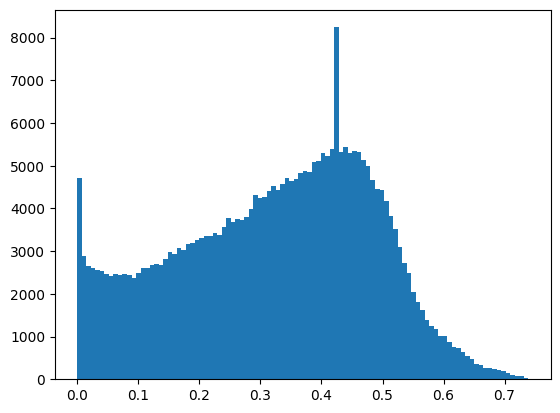

In [49]:
plt.hist((obs_arr[:, :, 3 * n_particles : 4 * n_particles].flatten() + 5)/6, bins = 100)

## Run Model

In [31]:
model_save_dir = "models/rl_qst"
tb_log_dir = "tb_logs/rl_qst/1_qubit"

In [32]:
run_name = "A2C_default_pure"
model_save_path = f"{model_save_dir}/{run_name}"

batch_size = 16
n_measurements = 1000
n_train_episodes = 16
eval_episode_freq = 1
n_eval_episodes = 20

train_env = DummyVecEnv([lambda: Monitor(AQSTEnv(n_measurements = n_measurements)) for _ in range(batch_size)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False)

eval_env = DummyVecEnv([lambda: Monitor(AQSTEnv(n_measurements = n_measurements))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

eval_callback = EvalCallback(eval_env, best_model_save_path=model_save_path,
                             deterministic=True, render=False, n_eval_episodes = n_eval_episodes,
                             eval_freq = eval_episode_freq * n_measurements)


model = A2C("MlpPolicy", train_env, tensorboard_log = tb_log_dir)
model.learn(batch_size * n_measurements * n_train_episodes, tb_log_name=run_name, callback = eval_callback)

Eval num_timesteps=16000, episode_reward=20.08 +/- 4.96
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=32000, episode_reward=22.27 +/- 4.30
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=19.94 +/- 4.73
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=64000, episode_reward=21.06 +/- 4.55
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=18.65 +/- 4.59
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=18.84 +/- 6.74
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=112000, episode_reward=19.20 +/- 5.34
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=128000, episode_reward=18.83 +/- 7.04
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=144000, episode_reward=20.01 +/- 4.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=160000, episode_reward=21.01 +/- 5.06
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=176000, episode_reward=20.66 +/- 5.66
Episo

See what the RL is doing wiht a given environment!

In [34]:
eval_env = DummyVecEnv([lambda: Monitor(AQSTEnv(n_measurements = n_measurements))])
eval_env = VecNormalize(eval_env, norm_obs = True, norm_reward=False)

best_model = A2C.load(f"{model_save_path}/best_model", eval_env)
    
#best_model.set_env(eval_env)
obs = eval_env.reset()

actions = []
rews = []

for _ in range(1000):
    action, _states = model.predict(obs, deterministic = True)
    obs, rewards, dones, info = eval_env.step(action)
    
    actions.append(action)
    rews.append(rewards)
    
#print(actions)
for action in actions[::20]: print(action)

[[-0.0085247  -0.04156029]]
[[0.02742405 0.02410996]]
[[0.25762588 1.        ]]
[[0.4161497 1.       ]]
[[0.16069362 0.99929816]]
[[-0.10922924  0.97690433]]
[[0.35516363 0.77012044]]
[[-0.02382629  0.6761413 ]]
[[0.10383001 0.575911  ]]
[[-0.07946776  0.23665775]]
[[0.12386031 0.5455264 ]]
[[0.22004873 0.3867467 ]]
[[0.13104972 0.21246164]]
[[0.00189072 0.31479883]]
[[0.05766859 0.41475177]]
[[0.61828923 1.        ]]
[[0.62405425 1.        ]]
[[0.5222611 1.       ]]
[[0.69441926 0.9512723 ]]
[[0.61515415 1.        ]]
[[0.49926183 1.        ]]
[[0.66194326 0.96863836]]
[[0.5939361 1.       ]]
[[0.5308078 1.       ]]
[[0.5423825 1.       ]]
[[0.6516099  0.94422036]]
[[0.6445394 0.7994402]]
[[0.6181784 0.9191485]]
[[0.22365564 1.        ]]
[[0.21006294 1.        ]]
[[0.18841207 1.        ]]
[[0.18825057 1.        ]]
[[0.20535307 1.        ]]
[[0.27139565 1.        ]]
[[0.28665212 1.        ]]
[[0.2306318 1.       ]]
[[0.28086913 1.        ]]
[[0.08546661 1.        ]]
[[0.18808754 1.     

Compare with Random and Info strats

In [62]:
import time

n_steps = 1000
n_envs = 16
rews = np.zeros((n_envs, 4, n_steps))

for i in range(0, n_envs):
    print(f"env {i}")
    
    rews[i, 0] = observe_run(model_type = INFO)[1]
    
    rews[i, 1] = observe_run(model_type = RANDOM)[1]
    
    rews[i, 2] = observe_run(model_type = RL, model = best_model)[1]
    
    rews[i, 3] = observe_run(model_type = CONSTANT, model = best_model)[1]

env 0
env 1
env 2
env 3
env 4
env 5
env 6
env 7
env 8
env 9
env 10
env 11
env 12
env 13
env 14
env 15


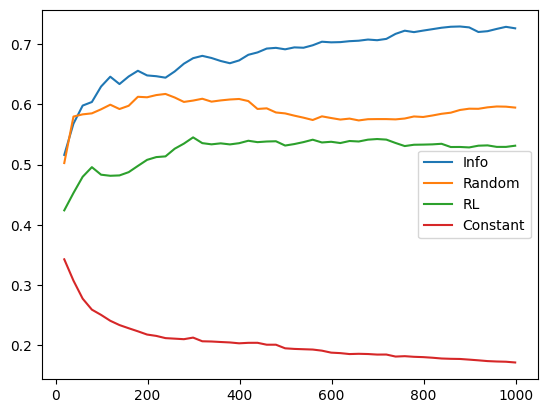

In [63]:
measure_freq = 20
x_arr = np.arange(measure_freq - 1, n_steps, measure_freq)

plt.plot(x_arr, np.mean(rews, axis = 0)[0, x_arr], label = "Info")
plt.plot(x_arr, np.mean(rews, axis = 0)[1, x_arr], label = "Random")
plt.plot(x_arr, np.mean(rews, axis = 0)[2, x_arr], label = "RL")
plt.plot(x_arr, np.mean(rews, axis = 0)[3, x_arr], label = "Constant")

plt.legend()

In [ ]:
run_name = "A2C_fix_state"
model_save_path = f"{model_save_dir}/{run_name}"


particle_states = Posterior(n_particles).particle_states
def make_env():
    return AQSTEnv(particle_states, n_measurements = 100)

train_env = DummyVecEnv([lambda: Monitor(make_env()) for _ in range(32)])

eval_env = AQSTEnv(particle_states, n_measurements = 100)
eval_callback = EvalCallback(eval_env, best_model_save_path=model_save_path,
                             eval_freq=32_000, deterministic=True, render=False, n_eval_episodes = 20)


model = A2C("MlpPolicy", train_env, tensorboard_log = tb_log_dir)
model.learn(512_000, callback=eval_callback, tb_log_name=run_name)

## Block experiment!

In [61]:
block_size = 50
n_configs = 10
n_tests = 32

def run_block(n_configs, block_size, hidden_state, adaptive):
    infidelity_arr_bayes = []
    posterior = Posterior()

    for i in range(n_configs):

        if not adaptive:
                config = pi * np.random.rand(2)
        
        else:
            config = posterior.get_best_config()
    
        for j in range(block_size):
            
            res = hidden_state.measure_along_axis(config)
            posterior.update(config, res)

        infidelity_arr_bayes.append(1 - state_fidelity(posterior.get_best_guess(), hidden_state.hidden_state))
        
    return infidelity_arr_bayes


infidelities = np.zeros((n_tests, 2, n_configs))

for i in range(n_tests):
    print(f"Running {i}")
    hidden_state = HiddenState(random_density_matrix(2).data)
    
    infidelities[i, 0] = run_block(n_configs, block_size, hidden_state, adaptive = True)
    infidelities[i, 1] = run_block(n_configs, block_size, hidden_state, adaptive = False)
    

Running 0
Running 1
Running 2
Running 3
Running 4
Running 5
Running 6
Running 7
Running 8
Running 9
Running 10
Running 11
Running 12
Running 13
Running 14
Running 15
Running 16
Running 17
Running 18
Running 19
Running 20
Running 21
Running 22
Running 23
Running 24
Running 25
Running 26
Running 27
Running 28
Running 29
Running 30
Running 31


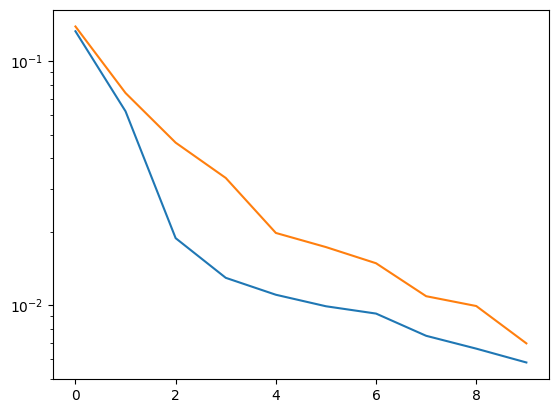

In [62]:
avgs = np.mean(infidelities, axis = 0)
x_arr = np.arange(n_configs)
plt.plot(x_arr, avgs[0])
plt.plot(x_arr, avgs[1])

plt.yscale('log')
#plt.xscale('log')

## Distribution size

In [56]:
def run_size(hidden_state, adaptive, n_steps):
    size_arr = []
    posterior = Posterior()

    for i in range(n_steps):

        if not adaptive:
                config = pi * np.random.rand(2)
        
        else:
            config = posterior.get_best_config()
            
        res = hidden_state.measure_along_axis(config)
        posterior.update(config, res)
        
        size = -np.sum(posterior.particle_weights * np.log(posterior.particle_weights), axis = -1)
        
        size_arr.append(size)
        
    return size_arr

sizes = run_size(HiddenState(random_density_matrix(2).data), adaptive = True, n_steps = 500)
sizes_2 = run_size(HiddenState(random_density_matrix(2).data), adaptive = False, n_steps = 500)

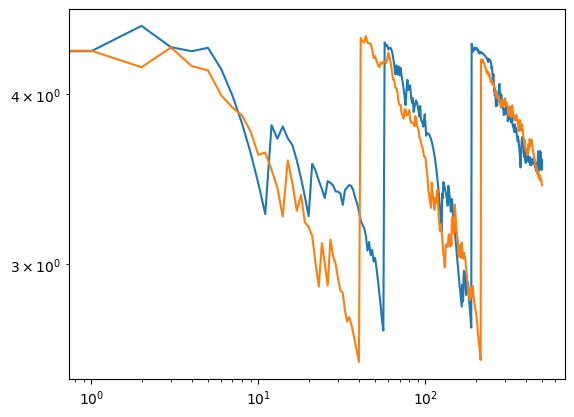

In [57]:
plt.plot(np.arange(500), sizes)
plt.plot(np.arange(500), sizes_2)

plt.yscale('log')
plt.xscale('log')